**22435004019 - BARIŞ KOL**

In [2]:
import torch
import torchvision.datasets as datasets
import torch.nn as nn 
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
mnistDataSet = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor()) 
train_set , validation_set = torch.utils.data.random_split(mnistDataSet, [5000, 55000], generator=torch.Generator().manual_seed(42))
print(f"Eğitim seti: {len(train_set)} adet")
print(f"Doğrulama seti: {len(validation_set)} adet")

Eğitim seti: 5000 adet
Doğrulama seti: 55000 adet


In [5]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_set, 
                                          batch_size=256, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'validation'  : torch.utils.data.DataLoader(validation_set, 
                                          batch_size=256, 
                                          shuffle=True, 
                                          num_workers=1),
}

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=64,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.AvgPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=64,              
                out_channels=128,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.AvgPool2d(kernel_size=2),    
        )


        self.fullyCon = nn.Sequential(
            nn.Linear(128 * 7 * 7, 1280),
            nn.ReLU(),
            nn.Linear(1280, 640),
            nn.ReLU(),
            nn.Linear(640, 10),
            nn.Softmax(dim = 1)
            )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)    
        x = x.view(x.size(0), -1)
        output = self.fullyCon(x)
        return output  


In [7]:
def trainAndValidation(cnn, loaders, lr):
  epochs  = 20
  trainLossList = []
  validLossList = []
  optimizer = torch.optim.SGD(cnn.parameters(), lr = lr, momentum=0.9) 
  lossFunc = nn.CrossEntropyLoss()

  print("Begin training...") 
  for epoch in range(epochs):
    runningTrainLoss = 0.0 
    runningValidationLoss = 0.0 

    cnn.train() 
    for i, (images, labels) in enumerate(loaders['train']):
      images, labels = images.to(device), labels.to(device)
      output = cnn(images)
      loss = lossFunc(output, labels)
      runningTrainLoss += loss.item()
      optimizer.zero_grad() 
      loss.backward()    
      optimizer.step()
    trainLossValue = runningTrainLoss/len(loaders['train'])
    trainLossList.append(trainLossValue)
    
    cnn.eval() 
    for i, (data, labels) in enumerate(loaders['validation']):
      data, labels = data.to(device), labels.to(device)
      output = cnn(data)
      loss = lossFunc(output,labels)
      runningValidationLoss += loss.item()  

    valLossValue = runningValidationLoss/len(loaders['validation'])   
    validLossList.append(valLossValue)

    if((epoch+1) % 5 == 0):
      print("Epoch: {} / {}, TrainLoss: {:.3f} ValidationLoss: {:.3f}".format(epoch+1, epochs, trainLossList[-1], validLossList[-1]))
      
  print("Finished training.") 

  return trainLossList, validLossList
    

In [8]:
learningRate = [0.1,0.01,0.001]
cnnRate01TrainLossList = []
cnnRate01ValidLossList = []
cnnRate02TrainLossList = []
cnnRate02ValidLossList = []
cnnRate03TrainLossList = []
cnnRate03ValidLossList = []

for rate in learningRate:
  cnn = CNN().to(device)
  trainLossList, validLossList = trainAndValidation(cnn,loaders,rate)
  if(rate == 0.1):
    cnnRate01TrainLossList.append(trainLossList)
    cnnRate01ValidLossList.append(validLossList)
  elif(rate == 0.01):
    cnnRate02TrainLossList.append(trainLossList)
    cnnRate02ValidLossList.append(validLossList)
  elif(rate == 0.001):
    cnnRate03TrainLossList.append(trainLossList)
    cnnRate03ValidLossList.append(validLossList)
    
  print(f"{rate} değeri için eğitim tamamlandı.")


Begin training...
Epoch: 5 / 20, TrainLoss: 2.214 ValidationLoss: 2.025
Epoch: 10 / 20, TrainLoss: 1.730 ValidationLoss: 1.720
Epoch: 15 / 20, TrainLoss: 1.689 ValidationLoss: 1.694
Epoch: 20 / 20, TrainLoss: 1.678 ValidationLoss: 1.684
Finished training.
0.1 değeri için eğitim tamamlandı.
Begin training...
Epoch: 5 / 20, TrainLoss: 2.302 ValidationLoss: 2.302
Epoch: 10 / 20, TrainLoss: 2.301 ValidationLoss: 2.301
Epoch: 15 / 20, TrainLoss: 2.300 ValidationLoss: 2.300
Epoch: 20 / 20, TrainLoss: 2.299 ValidationLoss: 2.299
Finished training.
0.01 değeri için eğitim tamamlandı.
Begin training...
Epoch: 5 / 20, TrainLoss: 2.303 ValidationLoss: 2.303
Epoch: 10 / 20, TrainLoss: 2.303 ValidationLoss: 2.303
Epoch: 15 / 20, TrainLoss: 2.302 ValidationLoss: 2.302
Epoch: 20 / 20, TrainLoss: 2.302 ValidationLoss: 2.302
Finished training.
0.001 değeri için eğitim tamamlandı.


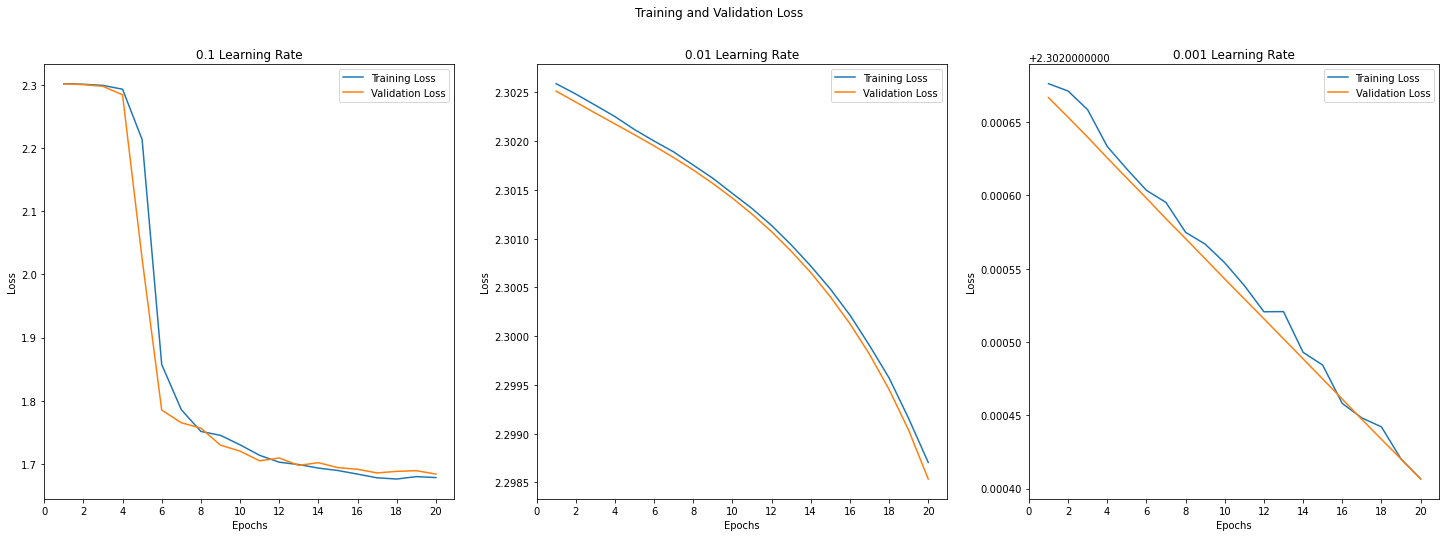

In [10]:
epochs = range(1,21)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(25, 8)
fig.suptitle('Training and Validation Loss')
ax1.plot(epochs,cnnRate01TrainLossList[0], label='Training Loss')
ax1.plot(epochs,cnnRate01ValidLossList[0], label='Validation Loss')
ax1.set_title('0.1 Learning Rate')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_xticks(np.arange(0, 21, 2))
ax1.legend(loc='best')

ax2.plot(epochs,cnnRate02TrainLossList[0], label='Training Loss')
ax2.plot(epochs,cnnRate02ValidLossList[0], label='Validation Loss')
ax2.set_title('0.01 Learning Rate')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_xticks(np.arange(0, 21, 2))
ax2.legend(loc='best')

ax3.plot(epochs,cnnRate03TrainLossList[0], label='Training Loss')
ax3.plot(epochs,cnnRate03ValidLossList[0], label='Validation Loss')
ax3.set_title('0.001 Learning Rate')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.set_xticks(np.arange(0, 21, 2))
ax3.legend(loc='best')

**Değerlendirme**

5000 adet eğitim ve 55000 adet doğrulama verileri için, 20 epoch kadar, Learning rate [0.1, 0.01, 0.001] değerleri ile eğitilen modelin eğitim ve doğrulama fonksiyonlarından gelen hata sonuçlarının grafiklerine göre, en başarılı sonucu veren öğrenme oranı **0.01** dir. Ancak her bir öğrenme oranı için loss fonksiyon sonuçları yüksek çıkmıştır.

0.1 eğitim oranı ile eğitilen modelin eğitim sonucunda 5. epoch'dan sonra doğrulama verilerinin loss fonksiyon sonuçları, eğitim verilerinin loss fonksiyon sonuçlarına yaklaşmaya başlaması, validation ve train verileri için loss fonksiyon sonuçlarının anlık değişimleri, 11. epochdan sonra doğrulama verilerinin loss fonksiyon sonuçlarının, eğitim verilerinin loss fonksiyon sonuçlarından fazla olması, overfitting (ezberleme, aşırı öğrenme) problemini  göstermektedir. Eğitim verilerinin yetersiz olması, epoch sayısının fazla olması, öğrenme oranın fazla olması bu sorunu doğurmuştur.

0.001 eğitim oranı ile eğitilen modelin eğitim sonucunda loss fonksiyon sonucu her epoch da 0.00005 kadar azalmaktadır. 20 epoch eğitimin sonunda loss fonksiyon sonuçlarının çok az azaldığı görülmektedir. Bu durum underfitting (eksik öğrenme) problemini doğurmaktadır. Model yeteri kadar eğitilememiş ve kıt kalmıştır.

0.01 eğitim oranı ile eğitilen modelin eğitim sonucunda test ve doğrulama verilerinin loss fonksiyon sonuçları ise belirtilen model ve parametler için daha doğru bir eğitim gerçekleştirdiği görülmektedir.






